<a href="https://colab.research.google.com/github/QustaB/Prediction_of_Production_Sales/blob/main/Prediction_of_Production_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Production Sales

- Auther: Qusta Bahu

## Project Overview

## Load and Inspect Data

In [384]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [385]:
import pandas as pd
fpath = '/content/drive/MyDrive/AXSOSACADEMY/01-Fundamentals/Week02/Data/sales_predictions_2023.csv'
df = pd.read_csv(fpath)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [386]:
df2 = df.copy()

In [387]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB




## Clean Data

### Rows and columns and data type

In [388]:
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns: ')

There are 8523 rows and 12 columns: 


Checking the data types:

In [389]:
for column in df.columns:
  print(f'{column}: {df[column].dtype}')

Item_Identifier: object
Item_Weight: float64
Item_Fat_Content: object
Item_Visibility: float64
Item_Type: object
Item_MRP: float64
Outlet_Identifier: object
Outlet_Establishment_Year: int64
Outlet_Size: object
Outlet_Location_Type: object
Outlet_Type: object
Item_Outlet_Sales: float64


- All other data types are as they should be.

### Duplicated Data
Checking for duplicated data:

In [390]:
print(df.duplicated().sum())

0


- no duplicates

### Unique values

In [391]:
df.nunique() / len(df) * 100

,0
Item_Identifier,18.291681
Item_Weight,4.869178
Item_Fat_Content,0.058665
Item_Visibility,92.455708
Item_Type,0.187727
Item_MRP,69.670304
Outlet_Identifier,0.117330
Outlet_Establishment_Year,0.105597
Outlet_Size,0.035199
Outlet_Location_Type,0.035199


no unique values

### Missing Values
Checking for missing values:

In [392]:
null_columns = df.isna().sum()
print(null_columns[null_columns>0])
null_percent = df.isna().sum() / len(df) * 100
print(null_percent[null_percent>0])

Item_Weight    1463
Outlet_Size    2410
dtype: int64
Item_Weight    17.165317
Outlet_Size    28.276428
dtype: float64


- Missing Values:
  - There are `1463` missing values in the `Item_Weight` column. (17.16%)
  - There are `2410` missing values in the `Outlet_Size` column. (3.29%)

- In order to make informed decisions about how to handle missing data, we will do some additional EDA.

<Axes: >

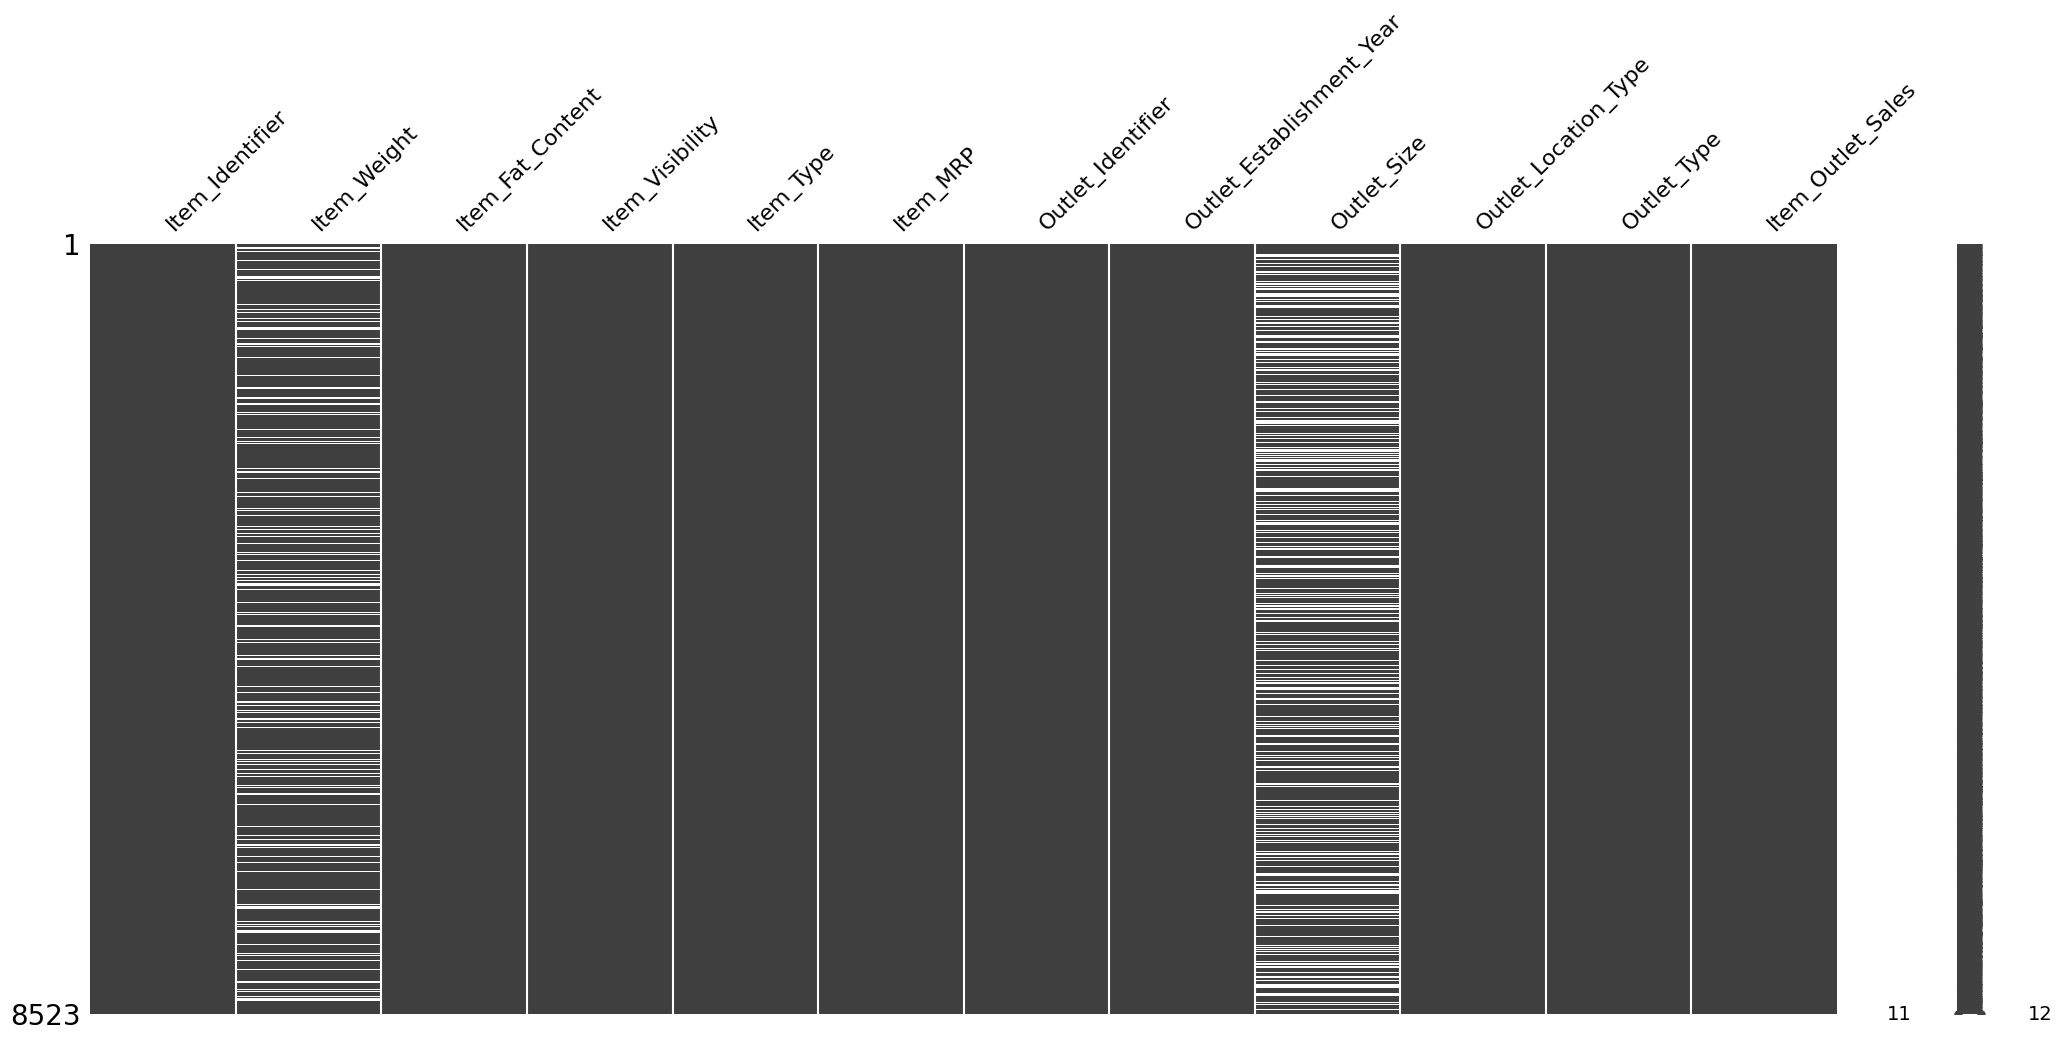

In [393]:
import missingno as msno
msno.matrix(df)

- We will  fill in the missing values with the word `Missing` so that the values will be filled in, but we will still be aware that those values are Missing.

- Filling in the `Outlet_Size` column with the word `Missing`.

In [394]:
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [395]:
df['Outlet_Size'] = df['Outlet_Size'].fillna('Missing')
df['Outlet_Size'].value_counts()

,count
Outlet_Size,
Medium,2793
Missing,2410
Small,2388
High,932


- Checking to make sure the values for the `Outlet_Size` column were filled in.

In [396]:
df['Outlet_Size'].isna().sum()

np.int64(0)

In [397]:
null_cat = df[cat_cols].isna().sum()
null_cat[null_cat>0]


,0


  - `Strategy #1`: To deal with the missing values, we could simply `drop` the missing values.
  - `Strategy #2`: To deal with the missing values, we could fill them in with the `most frequent` for this feature.
  - `Strategy #3`: To deal with the missing values, we could fill them in with the `median/mean value` for this feature.

- To maintain as much data as possible, we will not drop the data. So we will choose either `Strategy #2` or `Strategy #3`. To make this choice we will do a bit more investigating.

In [398]:
num_cols = df.select_dtypes('number').columns
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [399]:
null_columns = df.isna().sum()
print(null_columns[null_columns>0])

Item_Weight    1463
dtype: int64


In [400]:
null_weight = df['Item_Weight'].isna()
df[null_weight]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
8485,DRK37,NaN,Low Fat,0.043792,Soft Drinks,189.0530,OUT027,1985,Medium,Tier 3,Supermarket Type3,6261.8490
8487,DRG13,NaN,Low Fat,0.037006,Soft Drinks,164.7526,OUT027,1985,Medium,Tier 3,Supermarket Type3,4111.3150
8488,NCN14,NaN,Low Fat,0.091473,Others,184.6608,OUT027,1985,Medium,Tier 3,Supermarket Type3,2756.4120
8490,FDU44,NaN,Regular,0.102296,Fruits and Vegetables,162.3552,OUT019,1985,Small,Tier 1,Grocery Store,487.3656


- slicing dataframe by `Item_Type` and give the missing `Item_weight` the mean of the sliced item type

In [401]:
df['Item_Type'].value_counts()


,count
Item_Type,
Fruits and Vegetables,1232
Snack Foods,1200
Household,910
Frozen Foods,856
Dairy,682
Canned,649
Baking Goods,648
Health and Hygiene,520
Soft Drinks,445


In [402]:
mean_by_item_type = df.groupby('Item_Type')['Item_Weight'].mean()
mean_by_item_type

,Item_Weight
Item_Type,
Baking Goods,12.277108
Breads,11.346936
Breakfast,12.768202
Canned,12.305705
Dairy,13.426069
Frozen Foods,12.867061
Fruits and Vegetables,13.224769
Hard Drinks,11.400328
Health and Hygiene,13.142314


In [403]:
#df['Item_Weight'] = df['Item_Weight'].fillna(mean_by_item_type)
#df.loc[7,'Item_Weight']

In [404]:
df['Item_Weight']= df['Item_Weight'].fillna(round(mean_by_item_type,2))
df['Item_Weight'].isna().sum()

np.int64(1463)

In [405]:
df['Item_Weight'].describe()

,Item_Weight
count,7060.000000
mean,12.857645
std,4.643456
min,4.555000
25%,8.773750
50%,12.600000
75%,16.850000
max,21.350000


In [406]:
df['Item_Weight'].describe()

,Item_Weight
count,7060.000000
mean,12.857645
std,4.643456
min,4.555000
25%,8.773750
50%,12.600000
75%,16.850000
max,21.350000


In [407]:
df.isna().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


### Inconsistent

In [408]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [409]:
for col in cat_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  # Increasing readability by adding an empty line
  print('\n')

Value Counts for Item_Identifier
Item_Identifier
FDW13    10
FDG33    10
FDX31     9
FDT07     9
NCY18     9
         ..
FDO33     1
FDK57     1
FDT35     1
FDN52     1
FDE52     1
Name: count, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


Value Counts for Item_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


Value Counts for Outlet_Identifier
Outlet_Identifier
OUT027    935
OUT013

In [410]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


## Exploratory Data Analysis

## Feature Inspection